In [2]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.pulse import library as pulse_lib
from qiskit import assemble
from qiskit.tools.monitor import job_monitor
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization.pulse_v2 import draw
from utils import plot_shot_results, get_closest_multiple_of_16, save_value, load_value, load_Signal
from optimal_control import OptimalControl

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')


In [4]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [5]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [6]:
backend_defaults = backend.defaults()

In [7]:
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0

center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

Qubit 0 has an estimated frequency of 4.971657042036229 GHz.


In [8]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [9]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [10]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [11]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [12]:
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating 

print('The length of the gaussian pulse is',drive_samples)

The length of the gaussian pulse is 2704


In [13]:
def plot_shot_results(job):
    from matplotlib import pyplot as plt
    y_pulse_results = job.result(timeout=120)
    measure_list = y_pulse_results.get_counts()
    zero_list = []
    sum_list = []
    print(measure_list)
    for prob in measure_list:
        s = 0.
        for x in prob:
            s+=prob[x]
        sum_list.append(s)
        try:
            zero_list.append(prob['1'])
        except:
            zero_list.append(0)
    print(zero_list)
    plt.plot(sum_list)
    plt.plot(zero_list, '.')
    plt.show()

In [14]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

## 1. Define Qiskit default Clifford gate (In the schedule form)

In [15]:
from qiskit import QuantumCircuit
from qiskit import transpile, schedule as build_schedule

%matplotlib inline
x_circ = QuantumCircuit(1, 1)
x_circ.x(0)
x_circ = transpile(x_circ, backend)
x_schedule = build_schedule(x_circ, backend)

y_circ = QuantumCircuit(1, 1)
y_circ.y(0)
y_circ = transpile(y_circ, backend)
y_schedule = build_schedule(y_circ, backend)

z_circ = QuantumCircuit(1, 1)
z_circ.z(0)
z_circ = transpile(z_circ, backend)
z_schedule = build_schedule(z_circ, backend)

s_circ = QuantumCircuit(1, 1)
s_circ.s(0)
s_circ = transpile(s_circ, backend)
s_schedule = build_schedule(s_circ, backend)


xs_circ = QuantumCircuit(1, 1)
xs_circ.s(0)
xs_circ.x(0)
xs_circ = transpile(xs_circ, backend)
xs_schedule = build_schedule(xs_circ, backend)

ys_circ = QuantumCircuit(1, 1)
ys_circ.s(0)
ys_circ.y(0)
ys_circ = transpile(ys_circ, backend)
ys_schedule = build_schedule(ys_circ, backend)

zs_circ = QuantumCircuit(1, 1)
zs_circ.s(0)
zs_circ.z(0)
zs_circ = transpile(zs_circ, backend)
zs_schedule = build_schedule(zs_circ, backend)

h_circ = QuantumCircuit(1, 1)
h_circ.h(0)
backend = backend
h_circ = transpile(h_circ, backend)
h_schedule = build_schedule(h_circ, backend)

xh_circ = QuantumCircuit(1, 1)
xh_circ.h(0)
xh_circ.x(0)
backend = backend
xh_circ = transpile(xh_circ, backend)
xh_schedule = build_schedule(xh_circ, backend)

yh_circ = QuantumCircuit(1, 1)
yh_circ.h(0)
yh_circ.y(0)
yh_circ = transpile(yh_circ, backend)
yh_schedule = build_schedule(yh_circ, backend)

zh_circ = QuantumCircuit(1, 1)
zh_circ.h(0)
zh_circ.z(0)
zh_circ = transpile(zh_circ, backend)
zh_schedule = build_schedule(zh_circ, backend)

sh_circ = QuantumCircuit(1, 1)
sh_circ.h(0)
sh_circ.s(0)
sh_circ = transpile(sh_circ, backend)
sh_schedule = build_schedule(sh_circ, backend)

xsh_circ = QuantumCircuit(1, 1)
xsh_circ.h(0)
xsh_circ.s(0)
xsh_circ.x(0)
xsh_circ = transpile(xsh_circ, backend)
xsh_schedule = build_schedule(xsh_circ, backend)

ysh_circ = QuantumCircuit(1, 1)
ysh_circ.h(0)
ysh_circ.s(0)
ysh_circ.y(0)
ysh_circ = transpile(ysh_circ, backend)
ysh_schedule = build_schedule(ysh_circ, backend)

zsh_circ = QuantumCircuit(1, 1)
zsh_circ.h(0)
zsh_circ.s(0)
zsh_circ.z(0)
zsh_circ = transpile(zsh_circ, backend)
zsh_schedule = build_schedule(zsh_circ, backend)

hs_circ = QuantumCircuit(1, 1)
hs_circ.s(0)
hs_circ.h(0)
hs_circ = transpile(hs_circ, backend)
hs_schedule = build_schedule(hs_circ, backend)

xhs_circ = QuantumCircuit(1, 1)
xhs_circ.s(0)
xhs_circ.h(0)
xhs_circ.x(0)
xhs_circ = transpile(xhs_circ, backend)
xhs_schedule = build_schedule(xhs_circ, backend)

yhs_circ = QuantumCircuit(1, 1)
yhs_circ.s(0)
yhs_circ.h(0)
yhs_circ.y(0)
yhs_circ = transpile(yhs_circ, backend)
yhs_schedule = build_schedule(yhs_circ, backend)

zhs_circ = QuantumCircuit(1, 1)
zhs_circ.s(0)
zhs_circ.h(0)
zhs_circ.z(0)
zhs_circ = transpile(zhs_circ, backend)
zhs_schedule = build_schedule(zhs_circ, backend)

shs_circ = QuantumCircuit(1, 1)
shs_circ.s(0)
shs_circ.h(0)
shs_circ.s(0)
shs_circ = transpile(shs_circ, backend)
shs_schedule = build_schedule(shs_circ, backend)

xshs_circ = QuantumCircuit(1, 1)
xshs_circ.s(0)
xshs_circ.h(0)
xshs_circ.s(0)
xshs_circ.x(0)
xshs_circ = transpile(xshs_circ, backend)
xshs_schedule = build_schedule(xshs_circ, backend)

yshs_circ = QuantumCircuit(1, 1)
yshs_circ.s(0)
yshs_circ.h(0)
yshs_circ.s(0)
yshs_circ.y(0)
yshs_circ = transpile(yshs_circ, backend)
yshs_schedule = build_schedule(yshs_circ, backend)

zshs_circ = QuantumCircuit(1, 1)
zshs_circ.s(0)
zshs_circ.h(0)
zshs_circ.s(0)
zshs_circ.z(0)
zshs_circ = transpile(zshs_circ, backend)
zshs_schedule = build_schedule(zshs_circ, backend)


In [16]:
qiskit_clifford_schedules = [
0,\
x_schedule,\
y_schedule,\
z_schedule,\
s_schedule,\
xs_schedule,\
ys_schedule,\
zs_schedule,\
h_schedule,\
xh_schedule,\
yh_schedule,\
zh_schedule,\
sh_schedule,\
xsh_schedule,\
ysh_schedule,\
zsh_schedule,\
hs_schedule,\
xhs_schedule,\
yhs_schedule,\
zhs_schedule,\
shs_schedule,\
xshs_schedule,\
yshs_schedule,\
zshs_schedule,\
]

# 2. Define Gaussian Clifford Gates

In [17]:
pi_amp = 0.1338881278135786
x_pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='x_pi_pulse')
x_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp/2, 
                              sigma=drive_sigma,
                              name='x_halfpi_pulse')
minus_x_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=3*pi_amp/2, 
                              sigma=drive_sigma,
                              name='x_minus_halfpi_pulse')
y_pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp *1j, 
                              sigma=drive_sigma,
                              name='y_pi_pulse')
y_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp/2*1j, 
                              sigma=drive_sigma,
                              name='y_halfpi_pulse')
minus_y_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=3*pi_amp/2*1j, 
                              sigma=drive_sigma,
                              name='y_minus_halfpi_pulse')

## Our gaussian clifford gates !

In [21]:
x_pulse = pulse.Waveform(x_pi_pulse.samples, name = 'x')
y_pulse = pulse.Waveform(y_pi_pulse.samples, name = 'y')
z_pulse_samples = np.concatenate((x_pi_pulse.samples, y_pi_pulse.samples))
z_pulse = pulse.Waveform(z_pulse_samples, name = 'z')
s_pulse_samples = np.concatenate((y_halfpi_pulse.samples,x_halfpi_pulse.samples, minus_y_halfpi_pulse.samples))
s_pulse = pulse.Waveform(s_pulse_samples, name = 's')
xs_pulse_samples = np.concatenate((minus_x_halfpi_pulse.samples,y_halfpi_pulse.samples, minus_x_halfpi_pulse.samples))
xs_pulse = pulse.Waveform(xs_pulse_samples, name = 'xs')
ys_pulse_samples = np.concatenate((minus_y_halfpi_pulse.samples,minus_x_halfpi_pulse.samples, minus_y_halfpi_pulse.samples))
ys_pulse = pulse.Waveform(ys_pulse_samples, name = 'ys')
zs_pulse_samples = np.concatenate((y_halfpi_pulse.samples, minus_x_halfpi_pulse.samples, minus_y_halfpi_pulse.samples))
zs_pulse = pulse.Waveform(zs_pulse_samples, name = 'zs')
h_pulse = pulse.Waveform(np.concatenate((y_halfpi_pulse.samples, x_pi_pulse.samples)), name = 'h')
xh_pulse = pulse.Waveform(y_halfpi_pulse.samples, name = 'xh')
yh_pulse = pulse.Waveform(np.concatenate((x_pi_pulse.samples, y_halfpi_pulse.samples)), name = 'yh')
zh_pulse = pulse.Waveform(minus_y_halfpi_pulse.samples, name = 'zh')
sh_pulse = pulse.Waveform(np.concatenate((minus_x_halfpi_pulse.samples, minus_y_halfpi_pulse.samples)), name = 'sh')
xsh_pulse_samples = np.concatenate((minus_x_halfpi_pulse.samples,minus_y_halfpi_pulse.samples, x_pi_pulse.samples))
xsh_pulse = pulse.Waveform(xsh_pulse_samples, name = 'xsh')
ysh_pulse = pulse.Waveform(np.concatenate((minus_x_halfpi_pulse.samples, y_halfpi_pulse.samples)), name = 'ysh')
zsh_pulse_samples = np.concatenate((minus_x_halfpi_pulse.samples, y_halfpi_pulse.samples, x_pi_pulse.samples))
zsh_pulse = pulse.Waveform(zsh_pulse_samples, name = 'zsh')
hs_pulse = pulse.Waveform(np.concatenate((y_halfpi_pulse.samples, minus_x_halfpi_pulse.samples)), name = 'hs')
xhs_pulse = pulse.Waveform(np.concatenate((y_halfpi_pulse.samples, x_halfpi_pulse.samples)), name = 'xhs')
yhs_pulse_samples = np.concatenate((y_halfpi_pulse.samples, minus_x_halfpi_pulse.samples, y_pi_pulse.samples))
yhs_pulse = pulse.Waveform(yhs_pulse_samples, name = 'yhs')
zhs_pulse_samples =  np.concatenate((y_halfpi_pulse.samples, x_halfpi_pulse.samples, y_pi_pulse.samples))
zhs_pulse = pulse.Waveform(zhs_pulse_samples, name= 'zhs')
shs_pulse = pulse.Waveform(minus_x_halfpi_pulse.samples, name= 'shs')
xshs_pulse = pulse.Waveform(x_halfpi_pulse.samples, name= 'xshs')
yshs_pulse = pulse.Waveform(np.concatenate((minus_x_halfpi_pulse.samples, y_pi_pulse.samples)), name = 'yshs')
zshs_pulse = pulse.Waveform(np.concatenate((x_halfpi_pulse.samples, y_pi_pulse.samples)), name = 'zshs')

In [22]:
from qiskit.pulse import ShiftPhase
G_x_schedule = Play(x_pulse, drive_chan)
G_y_schedule = Play(y_pulse, drive_chan)
G_z_schedule = z_schedule

G_s_schedule = s_schedule
G_xs_schedule = G_s_schedule + G_x_schedule
G_ys_schedule = G_s_schedule + G_y_schedule
G_zs_schedule = G_s_schedule + G_z_schedule

G_h_schedule = G_z_schedule + Play(y_halfpi_pulse, drive_chan)
G_xh_schedule = Play(y_halfpi_pulse, drive_chan)
G_yh_schedule = G_z_schedule + Play(minus_y_halfpi_pulse, drive_chan)
G_zh_schedule = Play(minus_y_halfpi_pulse, drive_chan)

G_sh_schedule = Play(minus_y_halfpi_pulse, drive_chan) + ShiftPhase(np.pi/2, drive_chan)
G_xsh_schedule = Play(y_halfpi_pulse, drive_chan) + ShiftPhase(np.pi/2, drive_chan)
G_ysh_schedule = Play(y_halfpi_pulse, drive_chan) + G_s_schedule
G_zsh_schedule = Play(minus_y_halfpi_pulse, drive_chan) + G_s_schedule

G_hs_schedule = ShiftPhase(np.pi/2, drive_chan) + Play(y_halfpi_pulse, drive_chan)
G_xhs_schedule = G_s_schedule + Play(y_halfpi_pulse, drive_chan)
G_yhs_schedule = ShiftPhase(np.pi/2, drive_chan) + Play(minus_y_halfpi_pulse, drive_chan)
G_zhs_schedule = G_s_schedule + Play(minus_y_halfpi_pulse, drive_chan)

G_shs_schedule = Play(minus_x_halfpi_pulse, drive_chan)
G_xshs_schedule = Play(x_halfpi_pulse, drive_chan)
G_yshs_schedule = G_z_schedule + Play(minus_x_halfpi_pulse, drive_chan)
G_zshs_schedule = Play(minus_x_halfpi_pulse, drive_chan) + G_z_schedule

In [23]:
gaussian_clifford_gates = [
0,\
x_pulse,\
y_pulse,\
z_pulse,\
s_pulse,\
xs_pulse,\
ys_pulse,\
zs_pulse,\
h_pulse,\
xh_pulse,\
yh_pulse,\
zh_pulse,\
sh_pulse,\
xsh_pulse,\
ysh_pulse,\
zsh_pulse,\
hs_pulse,\
xhs_pulse,\
yhs_pulse,\
zhs_pulse,\
shs_pulse,\
xshs_pulse,\
yshs_pulse,\
zshs_pulse,\
]


In [24]:
gaussian_clifford_schedules = [
0,\
G_x_schedule,\
G_y_schedule,\
G_z_schedule,\
G_s_schedule,\
G_xs_schedule,\
G_ys_schedule,\
G_zs_schedule,\
G_h_schedule,\
G_xh_schedule,\
G_yh_schedule,\
G_zh_schedule,\
G_sh_schedule,\
G_xsh_schedule,\
G_ysh_schedule,\
G_zsh_schedule,\
G_hs_schedule,\
G_xhs_schedule,\
G_yhs_schedule,\
G_zhs_schedule,\
G_shs_schedule,\
G_xshs_schedule,\
G_yshs_schedule,\
G_zshs_schedule,\
]

# 3. Define SOC Clifford Gates

In [25]:
convert_factor = 1.64694154415136e-08,
omega = np.pi/(drive_samples_us*1e-6)
#delete below code

amplitude_pi_X_x = np.loadtxt("./amplitudes/ours/amplitude_pi_X_x.csv", delimiter = ',') * convert_factor
amplitude_pi_X_y = np.loadtxt("./amplitudes/ours/amplitude_pi_X_y.csv", delimiter = ',') * convert_factor
Signal = np.zeros(drive_samples, np.complex128)


for i in range(len(amplitude_pi_X_x)):
    Signal += amplitude_pi_X_x[i] * np.sin(omega * dt * np.arange(drive_samples) * (i+1))
    Signal += amplitude_pi_X_y[i] * np.sin(omega * dt * np.arange(drive_samples) * (i+1)) * 1j
print(max(Signal))

(0.25230838251875964-0.004076602062011545j)


In [26]:
amplitude_multiplier = 1
SOC_x_pi_pulse = pulse.Waveform(Signal*amplitude_multiplier, name = 'SOC_x_pi_pulse')
SOC_y_pi_pulse = pulse.Waveform(Signal*amplitude_multiplier*1j, name = 'SOC_y_pi_pulse')

In [27]:
convert_factor = 1.64694154415136e-08
omega = np.pi/(drive_samples_us*1e-6)
#delete below code

amplitude_pi_over_2_X_x = np.loadtxt("./amplitudes/ours/amplitude_pi_over_2_X_x.csv", delimiter = ',') * convert_factor
amplitude_pi_over_2_X_y = np.loadtxt("./amplitudes/ours/amplitude_pi_over_2_X_y.csv", delimiter = ',') * convert_factor
Signal = np.zeros(drive_samples, np.complex128)


for i in range(len(amplitude_pi_over_2_X_x)):
    Signal += amplitude_pi_over_2_X_x[i] * np.sin(omega * dt * np.arange(drive_samples) * (i+1))
    Signal += amplitude_pi_over_2_X_y[i] * np.sin(omega * dt * np.arange(drive_samples) * (i+1)) * 1j

In [28]:
amplitude_multiplier = 1
SOC_x_halfpi_pulse = pulse.Waveform(Signal*amplitude_multiplier, name = 'SOC_x_halfpi_pulse')
SOC_minus_x_halfpi_pulse = pulse.Waveform(-Signal*amplitude_multiplier, name = 'SOC_x_halfpi_pulse')
SOC_y_halfpi_pulse = pulse.Waveform(Signal*amplitude_multiplier*1j, name = 'SOC_y_halfpi_pulse')
SOC_minus_y_halfpi_pulse = pulse.Waveform(-Signal*amplitude_multiplier*1j, name = 'SOC_y_halfpi_pulse')

## OUR SOC Clifford Gates!

In [29]:
SOC_x_pulse = pulse.Waveform(SOC_x_pi_pulse.samples, name = 'SOC_x')
SOC_y_pulse = pulse.Waveform(SOC_y_pi_pulse.samples, name = 'SOC_y')
SOC_z_pulse_samples = np.concatenate((SOC_x_pi_pulse.samples, SOC_y_pi_pulse.samples))
SOC_z_pulse = pulse.Waveform(SOC_z_pulse_samples, name = 'SOC_z')
SOC_s_pulse_samples = np.concatenate((SOC_y_halfpi_pulse.samples,SOC_x_halfpi_pulse.samples, SOC_minus_y_halfpi_pulse.samples))
SOC_s_pulse = pulse.Waveform(SOC_s_pulse_samples, name = 'SOC_s')
SOC_xs_pulse_samples = np.concatenate((SOC_minus_x_halfpi_pulse.samples, SOC_y_halfpi_pulse.samples, SOC_minus_x_halfpi_pulse.samples))
SOC_xs_pulse = pulse.Waveform(SOC_xs_pulse_samples, name = 'SOC_xs')
SOC_ys_pulse_samples = np.concatenate((SOC_minus_y_halfpi_pulse.samples,SOC_minus_x_halfpi_pulse.samples, SOC_minus_y_halfpi_pulse.samples))
SOC_ys_pulse = pulse.Waveform(SOC_ys_pulse_samples, name = 'SOC_ys')
SOC_zs_pulse_samples = np.concatenate((SOC_y_halfpi_pulse.samples, SOC_minus_x_halfpi_pulse.samples, SOC_minus_y_halfpi_pulse.samples))
SOC_zs_pulse = pulse.Waveform(SOC_zs_pulse_samples, name = 'SOC_zs')
SOC_h_pulse_samples = np.concatenate((SOC_y_halfpi_pulse.samples, SOC_x_pi_pulse.samples))
SOC_h_pulse = pulse.Waveform(SOC_h_pulse_samples, name = 'SOC_h')
SOC_xh_pulse = pulse.Waveform(SOC_y_halfpi_pulse.samples, name = 'SOC_xh')
SOC_yh_pulse = pulse.Waveform(np.concatenate((SOC_x_pi_pulse.samples, SOC_y_halfpi_pulse.samples)), name = 'SOC_yh')
SOC_zh_pulse = pulse.Waveform(SOC_minus_y_halfpi_pulse.samples, name = 'SOC_zh')
SOC_sh_pulse = pulse.Waveform(np.concatenate((SOC_minus_x_halfpi_pulse.samples, SOC_minus_y_halfpi_pulse.samples)), name = 'SOC_sh')
SOC_xsh_pulse_samples = np.concatenate((SOC_minus_x_halfpi_pulse.samples,SOC_minus_y_halfpi_pulse.samples, SOC_x_pi_pulse.samples))
SOC_xsh_pulse = pulse.Waveform(SOC_xsh_pulse_samples, name = 'xsh')
SOC_ysh_pulse = pulse.Waveform(np.concatenate((SOC_minus_x_halfpi_pulse.samples, SOC_y_halfpi_pulse.samples)), name = 'SOC_ysh')
SOC_zsh_pulse_samples = np.concatenate((SOC_minus_x_halfpi_pulse.samples, SOC_y_halfpi_pulse.samples, SOC_x_pi_pulse.samples))
SOC_zsh_pulse = pulse.Waveform(SOC_zsh_pulse_samples, name = 'SOC_zsh')
SOC_hs_pulse = pulse.Waveform(np.concatenate((SOC_y_halfpi_pulse.samples, SOC_minus_x_halfpi_pulse.samples)), name = 'SOC_hs')
SOC_xhs_pulse = pulse.Waveform(np.concatenate((SOC_y_halfpi_pulse.samples, SOC_x_halfpi_pulse.samples)), name = 'SOC_xhs')
SOC_yhs_pulse_samples = np.concatenate((SOC_y_halfpi_pulse.samples, SOC_minus_x_halfpi_pulse.samples, SOC_y_pi_pulse.samples))
SOC_yhs_pulse = pulse.Waveform(SOC_yhs_pulse_samples, name = 'SOC_yhs')
SOC_zhs_pulse_samples =  np.concatenate((SOC_y_halfpi_pulse.samples, SOC_x_halfpi_pulse.samples, SOC_y_pi_pulse.samples))
SOC_zhs_pulse = pulse.Waveform(SOC_zhs_pulse_samples, name= 'SOC_zhs')
SOC_shs_pulse = pulse.Waveform(SOC_minus_x_halfpi_pulse.samples, name= 'SOC_shs')
SOC_xshs_pulse = pulse.Waveform(SOC_x_halfpi_pulse.samples, name= 'SOC_xshs')
SOC_yshs_pulse = pulse.Waveform(np.concatenate((SOC_minus_x_halfpi_pulse.samples, SOC_y_pi_pulse.samples)), name = 'SOC_yshs')
SOC_zshs_pulse = pulse.Waveform(np.concatenate((SOC_x_halfpi_pulse.samples, SOC_y_pi_pulse.samples)), name = 'SOC_zshs')

In [33]:
S_x_schedule = Play(SOC_x_pi_pulse, drive_chan)
S_y_schedule = Play(SOC_y_pi_pulse, drive_chan)
S_z_schedule = z_schedule
S_s_schedule = s_schedule
S_xs_schedule = S_s_schedule + S_x_schedule
S_ys_schedule = S_s_schedule + S_y_schedule
S_zs_schedule = S_s_schedule + S_z_schedule
S_h_schedule = S_z_schedule + Play(SOC_y_halfpi_pulse, drive_chan)
S_xh_schedule = Play(SOC_y_halfpi_pulse, drive_chan)
S_yh_schedule = S_z_schedule + Play(SOC_minus_y_halfpi_pulse, drive_chan)
S_zh_schedule = Play(SOC_minus_y_halfpi_pulse, drive_chan)
S_sh_schedule = Play(SOC_minus_y_halfpi_pulse, drive_chan) + ShiftPhase(np.pi/2, drive_chan)
S_xsh_schedule = Play(SOC_y_halfpi_pulse, drive_chan) + ShiftPhase(np.pi/2, drive_chan)
S_ysh_schedule = Play(SOC_y_halfpi_pulse, drive_chan) + S_s_schedule
S_zsh_schedule = Play(SOC_minus_y_halfpi_pulse, drive_chan) + S_s_schedule
S_hs_schedule = ShiftPhase(np.pi/2, drive_chan) + Play(SOC_y_halfpi_pulse, drive_chan)
S_xhs_schedule = S_s_schedule + Play(SOC_y_halfpi_pulse, drive_chan)
S_yhs_schedule = ShiftPhase(np.pi/2, drive_chan) + Play(SOC_minus_y_halfpi_pulse, drive_chan)
S_zhs_schedule = S_s_schedule + Play(SOC_minus_y_halfpi_pulse, drive_chan)
S_shs_schedule = Play(SOC_minus_x_halfpi_pulse, drive_chan)
S_xshs_schedule = Play(SOC_x_halfpi_pulse, drive_chan)
S_yshs_schedule = S_z_schedule + Play(SOC_minus_x_halfpi_pulse, drive_chan)
S_zshs_schedule = Play(SOC_minus_x_halfpi_pulse, drive_chan) + S_z_schedule

In [34]:
SOC_clifford_gates = [
0,\
SOC_x_pulse,\
SOC_y_pulse,\
SOC_z_pulse,\
SOC_s_pulse,\
SOC_xs_pulse,\
SOC_ys_pulse,\
SOC_zs_pulse,\
SOC_h_pulse,\
SOC_xh_pulse,\
SOC_yh_pulse,\
SOC_zh_pulse,\
SOC_sh_pulse,\
SOC_xsh_pulse,\
SOC_ysh_pulse,\
SOC_zsh_pulse,\
SOC_hs_pulse,\
SOC_xhs_pulse,\
SOC_yhs_pulse,\
SOC_zhs_pulse,\
SOC_shs_pulse,\
SOC_xshs_pulse,\
SOC_yshs_pulse,\
SOC_zshs_pulse,\
]


In [35]:
SOC_clifford_schedules = [
0,\
S_x_schedule,\
S_y_schedule,\
S_z_schedule,\
S_s_schedule,\
S_xs_schedule,\
S_ys_schedule,\
S_zs_schedule,\
S_h_schedule,\
S_xh_schedule,\
S_yh_schedule,\
S_zh_schedule,\
S_sh_schedule,\
S_xsh_schedule,\
S_ysh_schedule,\
S_zsh_schedule,\
S_hs_schedule,\
S_xhs_schedule,\
S_yhs_schedule,\
S_zhs_schedule,\
S_shs_schedule,\
S_xshs_schedule,\
S_yshs_schedule,\
S_zshs_schedule,\
]

# 3-2 Paper SOC

In [36]:
convert_factor = load_value('convert_factor')
drive_samples = int(500e-9/dt)
omega = np.pi/(500*1e-9)
#delete below code
drive_samples = get_closest_multiple_of_16(drive_samples)

Signal = load_Signal(omega, dt, drive_samples, "amplitudes/paper/amplitude_pi_X_x.csv", "amplitudes/paper/amplitude_pi_X_y.csv")
Signal *= 1e6 * convert_factor
amplitude_detuning_array = np.linspace(3.,8, 50)

In [37]:
amplitude_multiplier_paper_SOC = load_value('amplitude_multiplier_paper_SOC')
angle = load_value('paper_SOC_pi_angle')

Signal_final = Signal * amplitude_multiplier_paper_SOC
pulse_paper_SOC_pi_X = pulse.Waveform(Signal_final)
pulse_paper_SOC_pi_Y = pulse.Waveform(Signal_final*1j)

P_x_schedule = ShiftPhase(angle, drive_chan) + Play(pulse_paper_SOC_pi_X, drive_chan) + ShiftPhase(-angle, drive_chan)
P_y_schedule = ShiftPhase(angle, drive_chan) + Play(pulse_paper_SOC_pi_Y, drive_chan) + ShiftPhase(-angle, drive_chan)

In [38]:
convert_factor = load_value('convert_factor')
drive_samples = int(250e-9/dt)
omega = np.pi/(250*1e-9)
#delete below code
drive_samples = get_closest_multiple_of_16(drive_samples)

Signal = load_Signal(omega, dt, drive_samples, "amplitudes/paper/amplitude_pi_over_2_X_x.csv", "amplitudes/paper/amplitude_pi_over_2_X_y.csv")
Signal *= 1e6 * convert_factor
amplitude_detuning_array = np.linspace(1.2,2.1, 20)

In [39]:
amplitude_multiplier_paper_SOC_pi_over_2 = load_value('amplitude_multiplier_paper_SOC_pi_over_2')
paper_SOC_pi_over_2_angle = load_value('paper_SOC_pi_over_2_angle')
Signal_final = Signal * amplitude_multiplier_paper_SOC_pi_over_2
pulse_paper_SOC_pi_X_over_2 = pulse.Waveform(Signal_final)
pulse_paper_SOC_pi_Y_over_2 = pulse.Waveform(Signal_final*1j)
pulse_paper_SOC_pi_m_X_over_2 = pulse.Waveform(-Signal_final)
pulse_paper_SOC_pi_m_Y_over_2 = pulse.Waveform(-Signal_final*1j)

P_x_halfpi_schedule = ShiftPhase(paper_SOC_pi_over_2_angle, drive_chan) + Play(pulse_paper_SOC_pi_X_over_2, drive_chan) + ShiftPhase(-paper_SOC_pi_over_2_angle, drive_chan)
P_y_halfpi_schedule = ShiftPhase(paper_SOC_pi_over_2_angle, drive_chan) + Play(pulse_paper_SOC_pi_Y_over_2, drive_chan) + ShiftPhase(-paper_SOC_pi_over_2_angle, drive_chan)
P_minus_x_halfpi_schedule = ShiftPhase(paper_SOC_pi_over_2_angle, drive_chan) + Play(pulse_paper_SOC_pi_m_X_over_2, drive_chan) + ShiftPhase(-paper_SOC_pi_over_2_angle, drive_chan)
P_minus_y_halfpi_schedule = ShiftPhase(paper_SOC_pi_over_2_angle, drive_chan) + Play(pulse_paper_SOC_pi_m_Y_over_2, drive_chan) + ShiftPhase(-paper_SOC_pi_over_2_angle, drive_chan)

In [40]:
P_x_schedule = P_x_schedule
P_y_schedule = P_y_schedule
P_z_schedule = z_schedule
P_s_schedule = s_schedule
P_xs_schedule = P_s_schedule + P_x_schedule
P_ys_schedule = P_s_schedule + P_y_schedule
P_zs_schedule = P_s_schedule + P_z_schedule
P_h_schedule = P_z_schedule + P_y_halfpi_schedule
P_xh_schedule = P_y_halfpi_schedule
P_yh_schedule = P_z_schedule + P_minus_y_halfpi_schedule
P_zh_schedule = P_minus_y_halfpi_schedule
P_sh_schedule = P_minus_y_halfpi_schedule + ShiftPhase(np.pi/2, drive_chan)
P_xsh_schedule = P_y_halfpi_schedule + ShiftPhase(np.pi/2, drive_chan)
P_ysh_schedule = P_y_halfpi_schedule + P_s_schedule
P_zsh_schedule = P_minus_y_halfpi_schedule + P_s_schedule
P_hs_schedule = ShiftPhase(np.pi/2, drive_chan) + P_y_halfpi_schedule
P_xhs_schedule = P_s_schedule + P_y_halfpi_schedule
P_yhs_schedule = ShiftPhase(np.pi/2, drive_chan) + P_minus_y_halfpi_schedule
P_zhs_schedule = P_s_schedule + P_minus_y_halfpi_schedule
P_shs_schedule = P_minus_x_halfpi_schedule
P_xshs_schedule = P_x_halfpi_schedule
P_yshs_schedule = P_z_schedule + P_minus_x_halfpi_schedule
P_zshs_schedule = P_minus_x_halfpi_schedule + P_z_schedule

In [41]:
paper_clifford_schedules = [
0,\
P_x_schedule,\
P_y_schedule,\
P_z_schedule,\
P_s_schedule,\
P_xs_schedule,\
P_ys_schedule,\
P_zs_schedule,\
P_h_schedule,\
P_xh_schedule,\
P_yh_schedule,\
P_zh_schedule,\
P_sh_schedule,\
P_xsh_schedule,\
P_ysh_schedule,\
P_zsh_schedule,\
P_hs_schedule,\
P_xhs_schedule,\
P_yhs_schedule,\
P_zhs_schedule,\
P_shs_schedule,\
P_xshs_schedule,\
P_yshs_schedule,\
P_zshs_schedule,\
]

# 4. Randomized Benchmarking

### Clifford gates for making 0 / 1

In [42]:
t = np.zeros((24,2,2), dtype = np.complex64)
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0, -1j],[1j,0]])
Z = np.array([[1, 0],[0,-1]])
S = np.array([[1, 0],[0,1j]])
H = 1/ np.sqrt(2) * np.array([[1, 1],[1,-1]])

t[0]=  I# I
t[1] = X# X
t[2] = Y# Y
t[3] = Z # Z

t[4] = S # S
t[5] = X@S # XS
t[6] = Y@S # YS
t[7] = Z@S # ZS

t[8] = H # H
t[9] = X@H # XH
t[10] = Y@H # YH
t[11] = Z@H # ZH

t[12] = S@H # SH
t[13] = X@S@H # XSH
t[14] = Y@S@H # YSH
t[15] = Z@S@H # ZSH

t[16] = H@S # HS
t[17] = X@H@S # XHS
t[18] = Y@H@S # YHS
t[19] = Z@H@S # ZHS

t[20] = S@H@S # SHS
t[21] = X@S@H@S # XSHS
t[22] = Y@S@H@S # YSHS
t[23] = Z@S@H@S # ZSHS


In [43]:
def gates_for_making_01(sequence):
    result0 = []
    result1 = []
    temp_array0 = t[sequence[0]]
    for i in range(1, len(sequence)):
        temp_array0 =  t[sequence[i]] @ temp_array0
    for m in range(24):
        temp_array1 = t[m] @temp_array0 @ np.array([1,0])
        if (np.abs(temp_array1[0]) >= 1e-3 and np.abs(temp_array1[1]) < 1e-3):
            result0.append(m)
        if (np.abs(temp_array1[0]) < 1e-3 and np.abs(temp_array1[1]) >1e-3):
            result1.append(m)
    return result0, result1
    

In [44]:
#참고 표
gates_for_making_0 = {}
gates_for_making_1 = {}

for n in range(24):
    temp_list0 = []
    temp_list1 = []
    for m in range(24):
        temp_array = t[m] @ t[n] @ np.array([1,0])
        if (np.abs(temp_array[0]) > 1e-3 and np.abs(temp_array[1]) < 1e-3):
            temp_list0.append(m)
        if (np.abs(temp_array[0]) < 1e-3 and np.abs(temp_array[1]) > 1e-3):
            temp_list1.append(m)
    gates_for_making_0[n] = temp_list0
    gates_for_making_1[n] = temp_list1
print('gates for making 0:',gates_for_making_0)
print('gates for making 1:',gates_for_making_1)

gates for making 0: {0: [0, 3, 4, 7], 1: [1, 2, 5, 6], 2: [1, 2, 5, 6], 3: [0, 3, 4, 7], 4: [0, 3, 4, 7], 5: [1, 2, 5, 6], 6: [1, 2, 5, 6], 7: [0, 3, 4, 7], 8: [8, 11, 12, 15], 9: [8, 11, 12, 15], 10: [9, 10, 13, 14], 11: [9, 10, 13, 14], 12: [17, 18, 21, 22], 13: [16, 19, 20, 23], 14: [17, 18, 21, 22], 15: [16, 19, 20, 23], 16: [8, 11, 12, 15], 17: [8, 11, 12, 15], 18: [9, 10, 13, 14], 19: [9, 10, 13, 14], 20: [17, 18, 21, 22], 21: [16, 19, 20, 23], 22: [17, 18, 21, 22], 23: [16, 19, 20, 23]}
gates for making 1: {0: [1, 2, 5, 6], 1: [0, 3, 4, 7], 2: [0, 3, 4, 7], 3: [1, 2, 5, 6], 4: [1, 2, 5, 6], 5: [0, 3, 4, 7], 6: [0, 3, 4, 7], 7: [1, 2, 5, 6], 8: [9, 10, 13, 14], 9: [9, 10, 13, 14], 10: [8, 11, 12, 15], 11: [8, 11, 12, 15], 12: [16, 19, 20, 23], 13: [17, 18, 21, 22], 14: [16, 19, 20, 23], 15: [17, 18, 21, 22], 16: [9, 10, 13, 14], 17: [9, 10, 13, 14], 18: [8, 11, 12, 15], 19: [8, 11, 12, 15], 20: [16, 19, 20, 23], 21: [17, 18, 21, 22], 22: [16, 19, 20, 23], 23: [17, 18, 21, 22]}


In [45]:
def pulse_name(sequence):
    result =[]
    for n in range(len(sequence)):
        if sequence[n] != 0:
            name = gaussian_clifford_gates[sequence[n]].name
        if sequence[n]==0:
            name = 'I'
        result.append(name.split('_')[-1])
    return result

In [78]:
def get_fidelity_from_z_schedule(schedules, expected_final_result, detuning, print_result = True):
    num_shots_per_point = 1024
    program = assemble(schedules,
                       backend=backend,
                       meas_level=2,
                       meas_return='avg',
                       shots=num_shots_per_point,
                       schedule_los=[{drive_chan: center_frequency_Hz + detuning}] * len(schedules)) 
    job = backend.run(program)
    job_monitor(job)
    results = job.result(timeout=120)
    measure_list = results.get_counts()
    
    fidelity_list = []
    for n in range(len(schedules)):
        
        if expected_final_result[n] == 0:
            fidelity = measure_list[n]['0'] / (measure_list[n]['0'] + measure_list[n]['1'])
        elif expected_final_result[n] == 1:
            fidelity = measure_list[n]['1'] / (measure_list[n]['0'] + measure_list[n]['1'])
        if print_result:
            print(f'result: {measure_list[n]}')    
            print(f'fidelity: {fidelity}')
        fidelity_list.append(fidelity)
    return fidelity_list

In [79]:
def RB_z_schedule(sequence, base = 'Q', x_gate = 'Q', print_schedule = True):
    interleaved_sequence = sequence.tolist()
    for num in range(len(interleaved_sequence)):
        interleaved_sequence.insert(len(interleaved_sequence)-2*num-1,1)
    interleaved_gate_for_0, interleaved_gate_for_1 = gates_for_making_01(interleaved_sequence)
    reference_gate_for_0, reference_gate_for_1 = gates_for_making_01(sequence)
    
   
    expected_final_result = np.random.randint(2)
    
    
    if expected_final_result == 0:
        reference_recovery_gate = reference_gate_for_0[np.random.randint(len(reference_gate_for_0))]
        interleaved_recovery_gate = interleaved_gate_for_0[np.random.randint(len(interleaved_gate_for_0))]
    else:
        reference_recovery_gate = reference_gate_for_1[np.random.randint(len(reference_gate_for_1))]
        interleaved_recovery_gate = interleaved_gate_for_1[np.random.randint(len(interleaved_gate_for_1))]
     
    if print_schedule:
        print('Reference Sequence: recovery gate for 0:', reference_gate_for_0, '/  recovery gate for 1:',reference_gate_for_1)
        print('Interleaved Sequence: recovery gate for 0:', interleaved_gate_for_0, '/  recovery gate for 1:',interleaved_gate_for_1)
        print('The Expected Final_Result is', expected_final_result)
        print(f'Recovery Gate for reference sequence: {reference_recovery_gate} / {pulse_name([reference_recovery_gate])}')
        print(f'Recovery Gate for Interleaved sequence: {interleaved_recovery_gate} / {pulse_name([interleaved_recovery_gate])}')
    
    reference_schedule = pulse.Schedule()
    interleaved_schedule = pulse.Schedule()
    
    for k in range(len(sequence)):
        if x_gate == 'Q':
            interleaved_schedule += x_schedule
        elif x_gate == 'G':
            interleaved_schedule += G_x_schedule
        elif x_gate == 'S':
            interleaved_schedule += S_x_schedule
        elif x_gate == 'P':
            interleaved_schedule += P_x_schedule
        else:
            print('invalid x gate type')
            break
            
        if sequence[k] != 0:
            
            if base == 'Q':
                reference_schedule += qiskit_clifford_schedules[sequence[k]]
                interleaved_schedule += qiskit_clifford_schedules[sequence[k]]
            elif base == 'G':
                reference_schedule += gaussian_clifford_schedules[sequence[k]]
                interleaved_schedule += gaussian_clifford_schedules[sequence[k]]
            elif base == 'S':
                reference_schedule += SOC_clifford_schedules[sequence[k]]
                interleaved_schedule += SOC_clifford_schedules[sequence[k]]
            elif base == 'P':
                reference_schedule += paper_clifford_schedules[sequence[k]]
                interleaved_schedule += paper_clifford_schedules[sequence[k]] 
            else:
                print('invalid base type')
            
    if base == 'Q':                   
        if reference_recovery_gate != 0: 
            reference_schedule += qiskit_clifford_schedules[reference_recovery_gate]
        if interleaved_recovery_gate != 0: 
            interleaved_schedule += qiskit_clifford_schedules[interleaved_recovery_gate]
            
    elif base == 'G':
        if reference_recovery_gate != 0: 
            reference_schedule += gaussian_clifford_schedules[reference_recovery_gate]
        if interleaved_recovery_gate != 0: 
            interleaved_schedule += gaussian_clifford_schedules[interleaved_recovery_gate]
            
    elif base == 'S':
        if reference_recovery_gate != 0:
            reference_schedule += SOC_clifford_schedules[interleaved_recovery_gate]
        if interleaved_recovery_gate != 0: 
            interleaved_schedule += SOC_clifford_schedules[interleaved_recovery_gate]
    
    elif base == 'P':
        if reference_recovery_gate != 0:
            reference_schedule += paper_clifford_schedules[interleaved_recovery_gate]
        if interleaved_recovery_gate != 0: 
            interleaved_schedule += paper_clifford_schedules[interleaved_recovery_gate]
        
    reference_schedule += measure << reference_schedule.duration
    interleaved_schedule += measure << interleaved_schedule.duration
    
    return expected_final_result, reference_schedule, interleaved_schedule

In [80]:
def RB_z_schedules(m,n, base = 'Q', x_gate = 'Q', print_schedule = True):
    expected_final_results = []
    reference_schedules_list = []
    interleaved_schedules_list = []
    
    for num in range(n): 
        random_sequence = np.random.randint(24, size = m)
        if print_schedule:
            print('schdeule',num+1)
            print(f'Randomly Selected Sequence: {random_sequence} / {pulse_name(random_sequence)}')
        final_result, reference_schedule, interleaved_schedule = RB_z_schedule(random_sequence, base, x_gate, print_schedule = print_schedule)
        
        expected_final_results.append(final_result)
        reference_schedules_list.append(reference_schedule)
        interleaved_schedules_list.append(interleaved_schedule)
        if print_schedule:
            print('****'*5)
    return reference_schedules_list, interleaved_schedules_list, expected_final_results 

C:\Users\Owner\anaconda3\lib\site-packages\qiskit\pulse\schedule.py:1534: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments label are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  warnings.warn('Legacy pulse drawer is deprecated. '


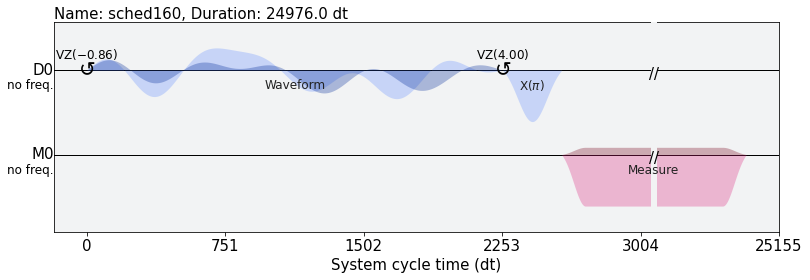

In [81]:
reference_schedules, interleaved_schedules, expected_final_results = RB_z_schedules(1,2,'Q','P', print_schedule = False)
#reference_schedules[0][2].draw(label = True)
interleaved_schedules[0].draw(label = True)

In [82]:
def RB_experiment(m, n, base = 'Q', x_gate = 'Q', n_sequence=1,detuning = 0, print_schedule = True, print_result = True): #(m은 reference sequence 길이, n은 reference seqeucne 개수)
                                                                                #(n_sequence는 한번에 실행하는 sequence 개수)
           
    print(f'Selected {n} reference sequences with length {m}')
    reference_schedules, interleaved_schedules, expected_final_results = RB_z_schedules(m,n, base, x_gate, print_schedule = print_schedule)
    
    reference_fidelity_list = []
    interleaved_fidelity_list = []

    average_reference_fidelity = 0
    average_interleaved_fidelity = 0

    total_experiment_num = np.ceil(n/n_sequence)
    
    experiment_schedule = []
    experiment_result = []
    
    for k in range(n):        
        experiment_schedule.append(reference_schedules[k])
        experiment_result.append(expected_final_results[k])
        if ((k+1) % n_sequence == 0):
            print(f'reference schedule {np.arange(k+2-n_sequence,k+2).tolist()}')
            fidelity_list = get_fidelity_from_z_schedule(experiment_schedule, experiment_result, detuning = detuning, print_result = print_result)
            average_reference_fidelity += sum(fidelity_list)
            reference_fidelity_list.extend(fidelity_list)
            experiment_schedule = []
            experiment_result = []
        elif (k == n-1):
            print(f'reference schedule {np.arange((total_experiment_num-1) * n_sequence +1,n+1).astype(np.int64).tolist()}')
            fidelity_list = get_fidelity_from_z_schedule(experiment_schedule, experiment_result,detuning = detuning, print_result = print_result)
            average_reference_fidelity += sum(fidelity_list)
            reference_fidelity_list.extend(fidelity_list)
            experiment_schedule = []
            experiment_result = []
       
    for k in range(n):        
        experiment_schedule.append(interleaved_schedules[k])
        experiment_result.append(expected_final_results[k])
        if ((k+1) % n_sequence == 0):
            print(f'interleaved schedule {np.arange(k+2-n_sequence,k+2).tolist()}')
            fidelity_list = get_fidelity_from_z_schedule(experiment_schedule, experiment_result, detuning = detuning, print_result = print_result)
            average_interleaved_fidelity += sum(fidelity_list)
            interleaved_fidelity_list.extend(fidelity_list)
            experiment_schedule = []
            experiment_result = []
        elif (k == n-1):
            print(f'interleaved schedule {np.arange((total_experiment_num-1) * n_sequence +1,n+1).astype(np.int64).tolist()}')
            fidelity_list = get_fidelity_from_z_schedule(experiment_schedule, experiment_result, detuning = detuning, print_result = print_result)
            average_interleaved_fidelity += sum(fidelity_list)
            interleaved_fidelity_list.extend(fidelity_list)
            experiment_schedule = []
            experiment_result = []

    
    average_reference_fidelity = average_reference_fidelity/n
    average_interleaved_fidelity = average_interleaved_fidelity/n
    
    print(f'The average reference fidelity is {average_reference_fidelity}')
    print(f'The average interleaved fidelity is {average_interleaved_fidelity}')
    print('#####' * 10)
    print('')
    return average_reference_fidelity, average_interleaved_fidelity


In [84]:
def save_results(ms, reference_fidelity, interleaved_fidelity, file_name):
    np.savetxt('Randomized_benchmarking_results/m_'+ file_name + ".txt", ms)
    np.savetxt('Randomized_benchmarking_results/reference_'+ file_name + ".txt", reference_fidelity)
    np.savetxt('Randomized_benchmarking_results/interleaved_'+ file_name + ".txt", interleaved_fidelity)


In [85]:
def load_results(file_name):
    ms = np.loadtxt('Randomized_benchmarking_results/m_'+ file_name + ".txt")
    reference_fidelity = np.loadtxt('Randomized_benchmarking_results/reference_'+ file_name + ".txt")
    interleaved_fidelity = np.loadtxt('Randomized_benchmarking_results/interleaved_'+ file_name + ".txt")
    return ms, reference_fidelity, interleaved_fidelity

In [106]:
def fit_results(ms, reference, interleaved):
    fit_params1, y_fit1 = fit_function(ms,
                                 reference, 
                                 lambda m, fidelity, A: (A *(2*fidelity - 1)** m ),
                                 [0.95, 1])

    fit_params2, y_fit2 = fit_function(ms,
                                 interleaved, 
                                 lambda m, fidelity, A: (A *(2*fidelity - 1)** m ),
                                 [0.95, 1])



    plt.scatter(ms, reference, color='black')
    plt.scatter(ms, interleaved, color='blue')

    plt.plot(ms, y_fit1, color='red')
    plt.plot(ms, y_fit2, color='red')

    reference_fidelity = fit_params1[0] 
    gate_fidelity = fit_params2[0] * fit_params1[0]
    plt.xlabel("# of clifford gates", fontsize=15)
    plt.ylabel("fidelity", fontsize=15)
    plt.show()
    print('reference_fidelity =', reference_fidelity)
    print('gate_fidelity =', gate_fidelity)
    return reference_fidelity, gate_fidelity

In [103]:
def run_and_save_RB_experiment(ms, file_name, base = 'Q', x_gate = 'Q', detuning = 0):
    experiment_num_per_m = 30
    average_reference_fidelity_per_m = np.zeros(len(ms))
    average_interleaved_fidelity_per_m = np.zeros(len(ms))

    base = base
    x_gate = x_gate
    n_sequence = 15

    for n in range(len(ms)):
        average_reference_fidelity_per_m[n], average_interleaved_fidelity_per_m[n]= RB_experiment(ms[n],experiment_num_per_m,base = base, x_gate = x_gate,n_sequence =n_sequence, detuning = detuning, print_schedule= False, print_result = False)
    save_results(ms, average_reference_fidelity_per_m, average_interleaved_fidelity_per_m, file_name = file_name)
    return average_reference_fidelity_per_m, average_interleaved_fidelity_per_m

### Base = 'Q', x_gate = 'Q'

In [110]:
ms = np.arange(1,400,10)
file_name = "Qiskit_Qiskit_detuning=0_2"
run_and_save_RB_experiment(ms, file_name, base = 'Q', x_gate = 'Q', detuning = 0)

Selected 30 reference sequences with length 1
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
interleaved schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
The average reference fidelity is 0.96181640625
The average interleaved fidelity is 0.954296875
##################################################

Selected 30 reference sequences with length 11
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Sta

(array([0.96181641, 0.96979167, 0.95966797, 0.95139974, 0.95139974,
        0.96119792, 0.953125  , 0.95104167, 0.94964193, 0.94462891,
        0.94267578, 0.94169922, 0.93291016, 0.93701172, 0.92415365,
        0.92128906, 0.91790365, 0.91370443, 0.91845703, 0.92373047,
        0.92236328, 0.91656901, 0.90836589, 0.90748698, 0.91686198,
        0.91028646, 0.90406901, 0.88684896, 0.89791667, 0.89335937,
        0.89296875, 0.8938151 , 0.87591146, 0.8718099 , 0.86214193,
        0.87639974, 0.86796875, 0.86930339, 0.85016276, 0.84039714]),
 array([0.95429688, 0.96572266, 0.94856771, 0.93720703, 0.93958333,
        0.94915365, 0.93590495, 0.92457682, 0.92600911, 0.91617839,
        0.91666667, 0.90498047, 0.90361328, 0.89983724, 0.88033854,
        0.87779948, 0.8796224 , 0.87513021, 0.86455078, 0.87096354,
        0.86943359, 0.87151693, 0.84401042, 0.84876302, 0.85345052,
        0.85380859, 0.82978516, 0.81689453, 0.83889974, 0.83841146,
        0.82978516, 0.81367188, 0.80009766, 0.

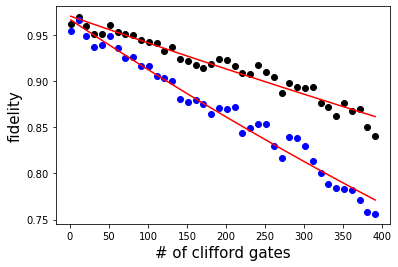

reference_fidelity = 0.9998476605644645
gate_fidelity = 0.9995586493267282


(0.9998476605644645, 0.9995586493267282)

In [116]:
file_name = "Qiskit_Qiskit_detuning=0_2"
m, r, i = load_results(file_name)
fit_results(m,r,i)

In [120]:
ms = np.arange(1,41,1)
file_name = "Qiskit_Qiskit_detuing=2_2"
run_and_save_RB_experiment(ms, file_name, base = 'Q', x_gate = 'Q', detuning = 2*MHz)

Selected 30 reference sequences with length 1
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job is queued

KeyboardInterrupt: 

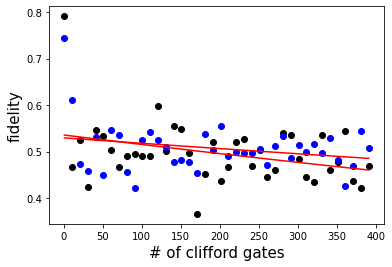

reference_fidelity = 0.9998061613609137
gate_fidelity = 0.9996948846217004


(0.9998061613609137, 0.9996948846217004)

In [127]:
file_name = "Qiskit_Qiskit_detuing=2"
m, r, i = load_results(file_name)
fit_results(m[:],r[:],i[:])

### Base = 'Q', x_gate = 'S'

In [114]:
ms = np.arange(1,82,2)
file_name = "Qiskit_SOC_detuing=0"
run_and_save_RB_experiment(ms, file_name, base = 'Q', x_gate = 'S', detuning = 0)

Selected 30 reference sequences with length 1
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
interleaved schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
The average reference fidelity is 0.9684895833333333
The average interleaved fidelity is 0.965625
##################################################

Selected 30 reference sequences with length 3
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job St

(array([0.96848958, 0.96676432, 0.97229818, 0.96318359, 0.96582031,
        0.96650391, 0.96370443, 0.96448568, 0.96500651, 0.96389974,
        0.96474609, 0.96689453, 0.96061198, 0.96054688, 0.96389974,
        0.95485026, 0.96608073, 0.96041667, 0.95810547, 0.95615234,
        0.95338542, 0.94928385, 0.95888672, 0.95022786, 0.94938151,
        0.94628906, 0.9516276 , 0.95289714, 0.95026042, 0.95934245,
        0.94609375, 0.94296875, 0.95302734, 0.94378255, 0.94189453,
        0.93616536, 0.94046224, 0.93538411, 0.93398437, 0.9234375 ,
        0.91901042]),
 array([0.965625  , 0.89254557, 0.87952474, 0.82522786, 0.79270833,
        0.74277344, 0.66575521, 0.68225911, 0.72939453, 0.6077474 ,
        0.60891927, 0.60901693, 0.56920573, 0.53935547, 0.54677734,
        0.58310547, 0.55218099, 0.58310547, 0.46705729, 0.46796875,
        0.5413737 , 0.49586589, 0.46699219, 0.52099609, 0.51822917,
        0.5320638 , 0.52167969, 0.53893229, 0.52779948, 0.47692057,
        0.50979818, 0.4773

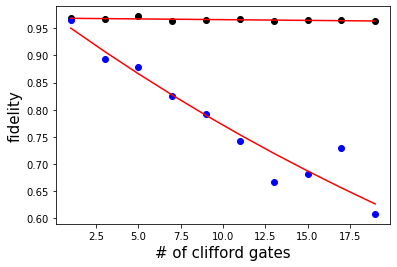

reference_fidelity = 0.9998581457392082
gate_fidelity = 0.9884047096098796


(0.9998581457392082, 0.9884047096098796)

In [123]:
file_name = "Qiskit_SOC_detuing=0"
m, r, i = load_results(file_name)
fit_results(m[:10],r[:10],i[:10])

In [115]:
ms = np.arange(1,82,2)
file_name = "Qiskit_SOC_detuing=2"
run_and_save_RB_experiment(ms, file_name, base = 'Q', x_gate = 'S', detuning = 2*MHz)

Selected 30 reference sequences with length 1
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
interleaved schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
The average reference fidelity is 0.7617838541666667
The average interleaved fidelity is 0.64462890625
##################################################

Selected 30 reference sequences with length 3
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
J

(array([0.76178385, 0.60804036, 0.60501302, 0.43066406, 0.55182292,
        0.51448568, 0.55501302, 0.5241862 , 0.50872396, 0.51552734,
        0.49397786, 0.40341797, 0.59169922, 0.42392578, 0.51106771,
        0.51936849, 0.51936849, 0.50052083, 0.54378255, 0.49394531,
        0.49238281, 0.52835286, 0.4343099 , 0.42639974, 0.56389974,
        0.54296875, 0.47216797, 0.51240234, 0.5422526 , 0.43850911,
        0.49384766, 0.47034505, 0.44065755, 0.52412109, 0.45673828,
        0.56526693, 0.50084635, 0.53339844, 0.54811198, 0.55195313,
        0.46565755]),
 array([0.64462891, 0.6765625 , 0.57815755, 0.56653646, 0.45563151,
        0.57093099, 0.46181641, 0.46067708, 0.43323568, 0.54355469,
        0.58574219, 0.50615234, 0.51813151, 0.56132812, 0.45302734,
        0.48616536, 0.43645833, 0.50992839, 0.57770182, 0.45286458,
        0.53902995, 0.51471354, 0.48336589, 0.49088542, 0.53772786,
        0.51070964, 0.52841797, 0.51666667, 0.54166667, 0.54329427,
        0.50071615, 0.5361

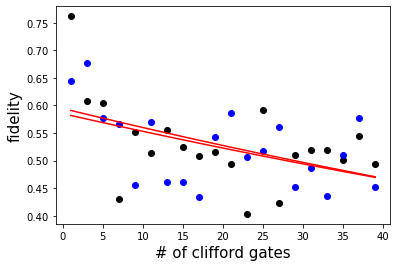

reference_fidelity = 0.9970152387367073
gate_fidelity = 0.9942110332055483


(0.9970152387367073, 0.9942110332055483)

In [125]:
file_name = "Qiskit_SOC_detuing=2"
m, r, i = load_results(file_name)
fit_results(m[:20], r[:20], i[:20])

### Base = 'Q', x_gate = 'G'

In [112]:
ms = np.arange(1,82,2)
file_name = "Qiskit_Gaussian_detuing=2"
run_and_save_RB_experiment(ms, file_name, base = 'Q', x_gate = 'G', detuning = 2*MHz)

Selected 30 reference sequences with length 1
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
interleaved schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
The average reference fidelity is 0.7540364583333333
The average interleaved fidelity is 0.40712890625
##################################################

Selected 30 reference sequences with length 3
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
J

(array([0.75403646, 0.58720703, 0.57516276, 0.55605469, 0.60524089,
        0.52688802, 0.57285156, 0.49244792, 0.47122396, 0.60654297,
        0.51354167, 0.55351562, 0.4289388 , 0.45644531, 0.44560547,
        0.43603516, 0.52115885, 0.50367839, 0.56774089, 0.49964193,
        0.4874349 , 0.56617839, 0.46692708, 0.48271484, 0.53261719,
        0.44876302, 0.51383464, 0.59287109, 0.53111979, 0.48004557,
        0.49710286, 0.54628906, 0.5202474 , 0.54544271, 0.48408203,
        0.57431641, 0.56227214, 0.55247396, 0.50901693, 0.52021484,
        0.52428385]),
 array([0.40712891, 0.4328125 , 0.42154948, 0.51917318, 0.45087891,
        0.5008138 , 0.53144531, 0.51097005, 0.50338542, 0.51861979,
        0.45924479, 0.48776042, 0.49013672, 0.47639974, 0.47998047,
        0.48007813, 0.48626302, 0.47490234, 0.49934896, 0.45764974,
        0.48457031, 0.51269531, 0.48886719, 0.45045573, 0.45693359,
        0.48723958, 0.52135417, 0.54163411, 0.51207682, 0.53977865,
        0.49427083, 0.5186

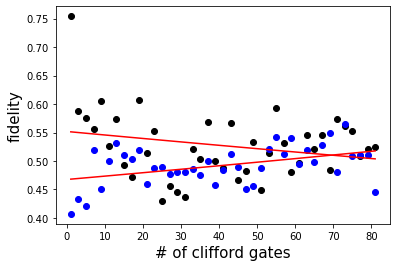

reference_fidelity = 0.9994381182720605
gate_fidelity = 1.0000666260381355


(0.9994381182720605, 1.0000666260381355)

In [126]:
file_name = "Qiskit_Gaussian_detuing=2"
m, r, i = load_results(file_name)
fit_results(m, r, i)

### base = Q, x_gate = P

In [113]:
ms = np.arange(1,82,2)
file_name = "Qiskit_Paper_detuing=2"
run_and_save_RB_experiment(ms, file_name, base = 'Q', x_gate = 'P', detuning = 2*MHz)

Selected 30 reference sequences with length 1
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
interleaved schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
The average reference fidelity is 0.7840494791666667
The average interleaved fidelity is 0.7613606770833333
##################################################

Selected 30 reference sequences with length 3
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 

(array([0.78404948, 0.59886068, 0.58359375, 0.51416016, 0.46582031,
        0.40885417, 0.5273763 , 0.48141276, 0.52786458, 0.4991862 ,
        0.54026693, 0.38141276, 0.55602214, 0.45159505, 0.47633464,
        0.53652344, 0.53736979, 0.43076172, 0.45380859, 0.54703776,
        0.46266276, 0.50403646, 0.44736328, 0.47711589, 0.45279948,
        0.4530599 , 0.46360677, 0.54316406, 0.46445313, 0.48798828,
        0.5226888 , 0.54010417, 0.39801432, 0.41992188, 0.46982422,
        0.57167969, 0.5703776 , 0.50384115, 0.55253906, 0.48365885,
        0.52929688]),
 array([0.76136068, 0.70764974, 0.67490234, 0.69251302, 0.63639323,
        0.63554687, 0.61754557, 0.56940104, 0.4710612 , 0.47467448,
        0.52783203, 0.48330078, 0.52457682, 0.59905599, 0.46064453,
        0.5508138 , 0.4797526 , 0.52288411, 0.45986328, 0.52845052,
        0.49075521, 0.49261068, 0.51744792, 0.49189453, 0.47955729,
        0.46591797, 0.55716146, 0.49794922, 0.54358724, 0.4883138 ,
        0.50276693, 0.5425

In [ ]:
file_name = "Qiskit_Paper_detuing=2"
m, r, i = load_results(file_name)
fit

In [61]:
ms = np.arange(1,82,2)
experiment_num_per_m = 30

average_reference_fidelity_per_m = np.zeros(len(ms))
reference_fidelity_per_m = np.zeros((len(ms), experiment_num_per_m))

average_interleaved_fidelity_per_m = np.zeros(len(ms))
interleaved_fidelity_per_m = np.zeros((len(ms), experiment_num_per_m))

In [83]:
n_sequence = 15
for n in range(21):
    average_reference_fidelity_per_m[n], average_interleaved_fidelity_per_m[n]= RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'P',n_sequence =n_sequence, print_schedule= False, print_result = False)

Selected 30 reference sequences with length 1
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
interleaved schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
The average reference fidelity is 0.96220703125
The average interleaved fidelity is 0.9583333333333334
##################################################

Selected 30 reference sequences with length 3
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
J

In [93]:
for n in range(21, 41):
    average_reference_fidelity_per_m[n], average_interleaved_fidelity_per_m[n]= RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'P',n_sequence =n_sequence, print_schedule= False, print_result = False)

Selected 30 reference sequences with length 43
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
interleaved schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
The average reference fidelity is 0.94599609375
The average interleaved fidelity is 0.826953125
##################################################

Selected 30 reference sequences with length 45
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job St

In [89]:
average_reference_fidelity_per_m[20]

0.9482421875

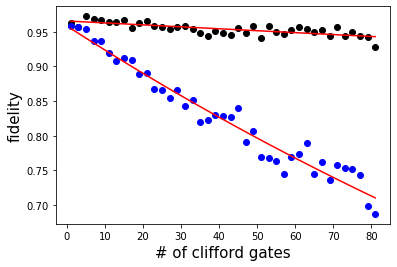

reference_fidelity = 0.9998533582780866
gate_fidelity = 0.998006560261829


(0.9998533582780866, 0.998006560261829)

In [97]:
fit_results(ms, average_reference_fidelity_per_m,average_interleaved_fidelity_per_m)

In [98]:
file_name = "Qiskit_Paper_detuning=0"
save_results(ms, average_reference_fidelity_per_m,average_interleaved_fidelity_per_m, file_name)

In [104]:
file_name = "test" 
ms = np.array([1])
run_and_save_RB_experiment(ms, file_name, base = 'Q', x_gate= 'Q', detuning = 0)

Selected 30 reference sequences with length 1
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
reference schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
interleaved schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
interleaved schedule [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Job Status: job has successfully run
The average reference fidelity is 0.9659830729166666
The average interleaved fidelity is 0.9663411458333333
##################################################



(array([0.96598307]), array([0.96634115]))

In [107]:
ms, r, i = load_results("test")
fit_results(ms, r, i)

TypeError: Improper input: N=2 must not exceed M=1